In [7]:
import multiprocessing
import random
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchio as tio
from unet import UNet

from scripts.utils.memory import get_total_memory
from scripts.utils.visualization import *
from scripts.load_data import *
from scripts.train import *

from miseval import evaluate


seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
%config InlineBackend.figure_format = 'retina'
num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 12, 6

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

%load_ext autoreload
%autoreload 2

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)
print('Device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Last run on Tue Jul 11 14:04:26 2023
TorchIO version: 0.18.92
Device: cuda


# Data Loading and Visualization

In [8]:
# We take a percentage of the data for training:
def split_training_data(metadata, train_ratio=0.8, vendor='A', save=False):
    n_total = metadata["Vendor"].value_counts()[vendor]
    n_train = int(n_total * train_ratio)
    indices = metadata.index[metadata["Vendor"] == vendor].tolist()
    train_indices = random.sample(indices, n_train)

    metadata.loc[train_indices, "Vendor"] = 'F'
    metadata.loc[train_indices, "Centre"] = 6

    print(f"total number of samples: {n_total}, train samples: {n_train}, Validation: {n_total-n_train}")
    if save:
        metadata_path = "Data/M&Ms/OpenDataset/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv"
        metadata.to_csv(metadata_path, index=False)
    
    return metadata


In [9]:
metadata_path = "Data/M&Ms/OpenDataset/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv"
metadata = pd.read_csv(metadata_path, index_col=1).drop(columns="Unnamed: 0")
metadata = split_training_data(metadata, train_ratio=0.8)
metadata.head(5)

total number of samples: 95, train samples: 76, Validation: 19


,VendorName,Vendor,Centre,ED,ES,Age,Pathology,Sex,Height,Weight
External code,,,,,,,,,,
A0S9V9,Siemens,F,6,0,9,67,DCM,M,180.0,88.0
A1D0Q7,Philips,B,2,0,9,79,HCM,F,NaN,88.0
A1D9Z7,Siemens,A,1,22,11,53,HCM,M,175.0,75.0
A1E9Q1,Siemens,F,6,0,9,16,DCM,M,175.0,75.0
A1K2P5,Canon,D,5,33,11,35,DCM,F,170.0,NaN


In [10]:
vendors = list(metadata.Vendor.unique())
vendors

['F', 'B', 'A', 'D', 'C']

In [39]:
transform = tio.RescaleIntensity((0, 1), percentiles=(0.5, 95.))
vendor_datasets_3D = []
for vendor in vendors:
    vendor_datasets_3D.append(load_vendor_3D(vendor, metadata, transform))

317it [00:07, 42.01it/s] 


Data/M&Ms/OpenDataset/ Dataset size: 76 subjects


317it [00:17, 18.06it/s]


Data/M&Ms/OpenDataset/ Dataset size: 125 subjects


317it [00:03, 97.27it/s] 


Data/M&Ms/OpenDataset/ Dataset size: 19 subjects


317it [00:09, 34.99it/s] 


Data/M&Ms/OpenDataset/ Dataset size: 50 subjects


317it [00:08, 39.01it/s] 

Data/M&Ms/OpenDataset/ Dataset size: 47 subjects


Subject(Keys: ('image', 'seg', 'id'); images: 2)
ScalarImage(shape: (2, 128, 128, 11); spacing: (0.99, 0.85, 8.00); orientation: LIP+; dtype: torch.FloatTensor; memory: 1.4 MiB)
LabelMap(shape: (2, 128, 128, 11); spacing: (0.99, 0.85, 8.00); orientation: LIP+; dtype: torch.FloatTensor; memory: 1.4 MiB)


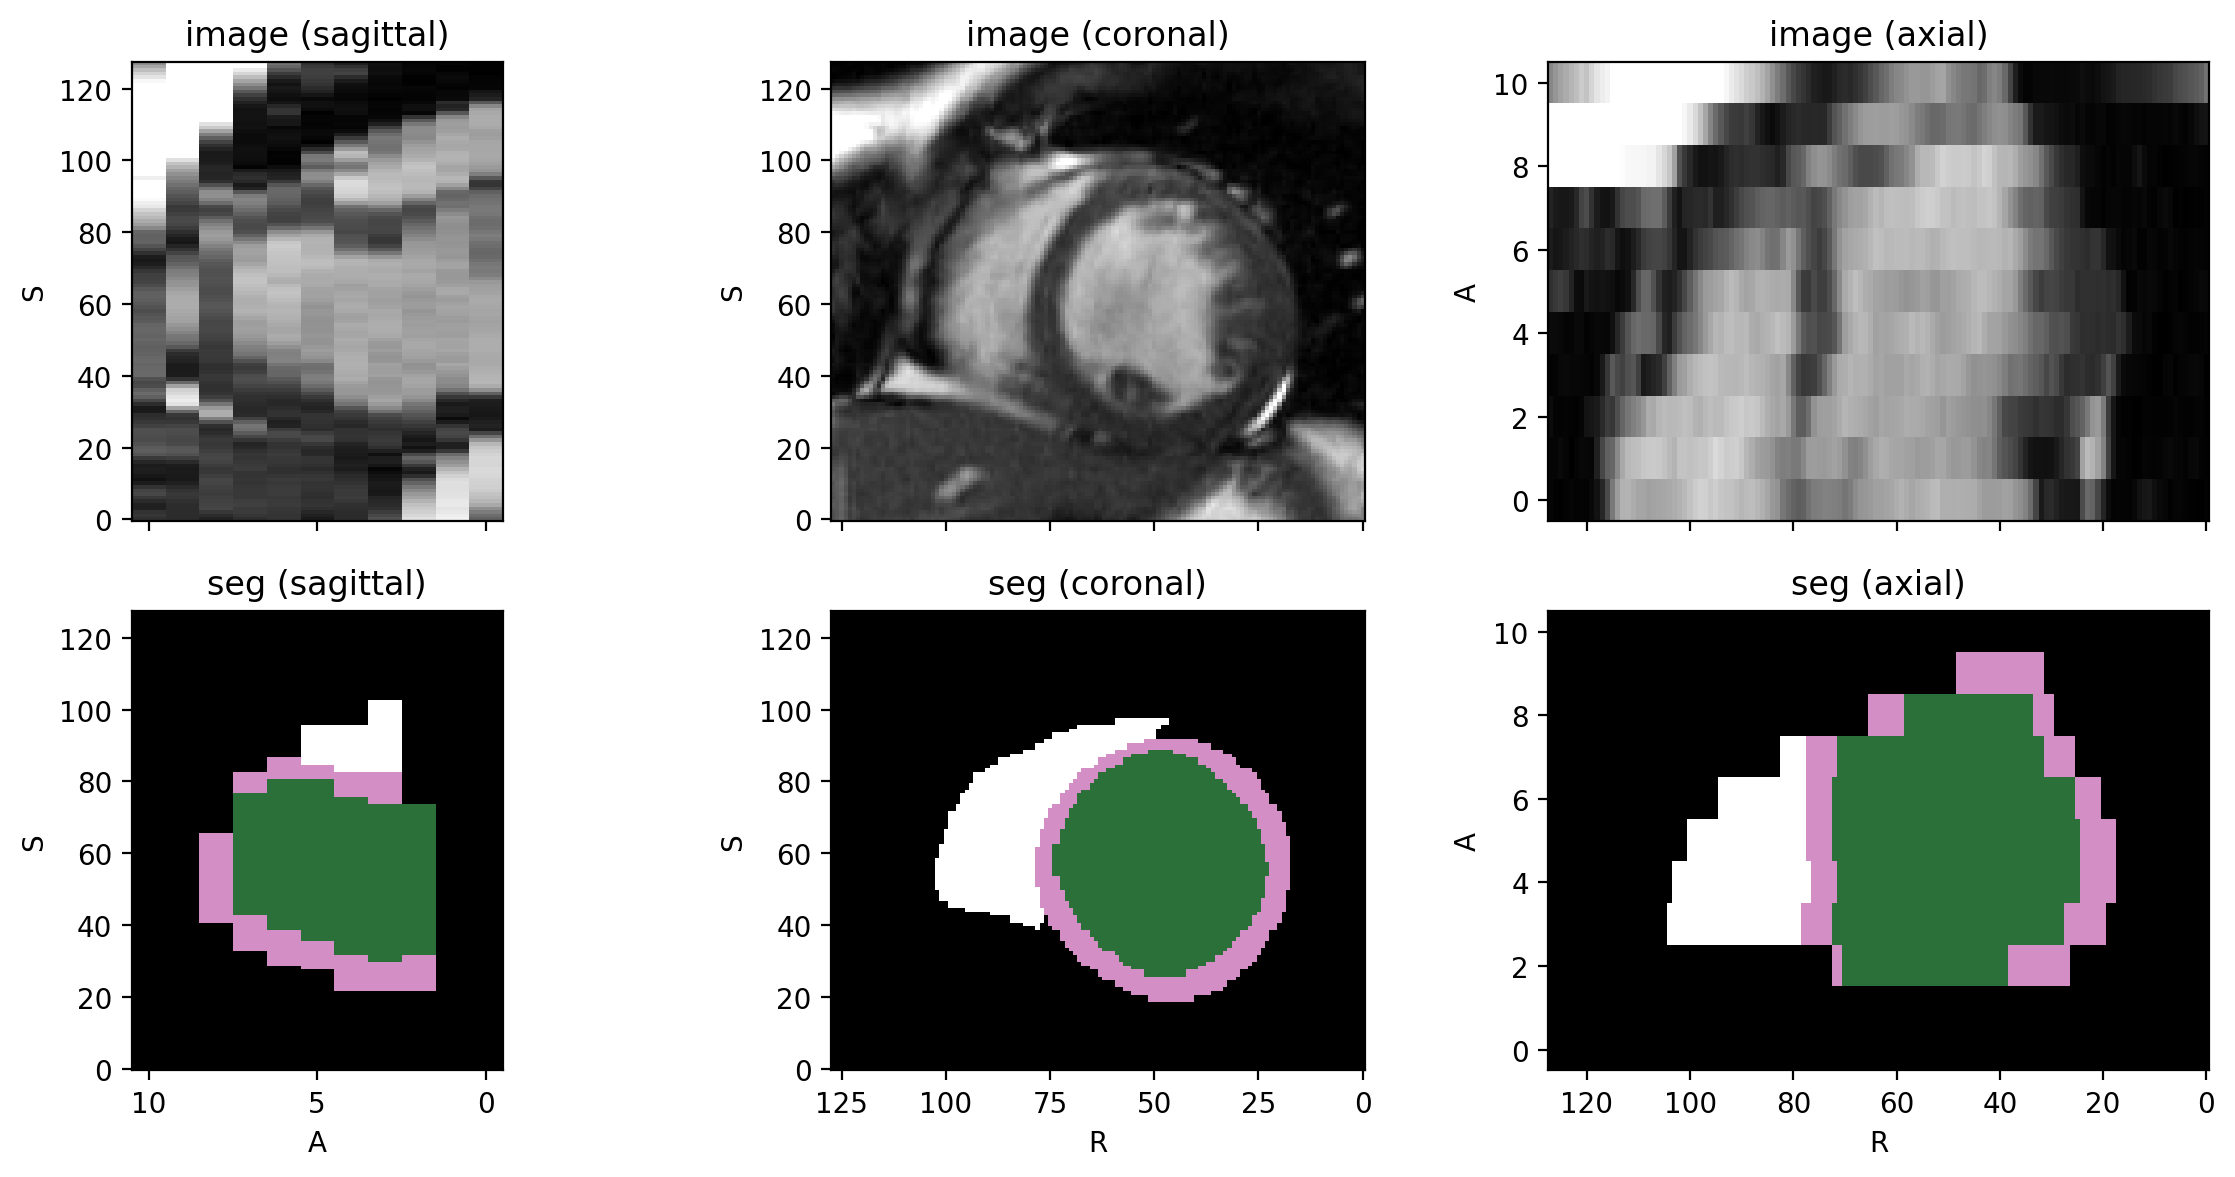

Subject(Keys: ('image', 'seg', 'id'); images: 2)
ScalarImage(shape: (2, 128, 128, 12); spacing: (1.13, 1.10, 10.00); orientation: PIR+; dtype: torch.FloatTensor; memory: 1.5 MiB)
LabelMap(shape: (2, 128, 128, 12); spacing: (1.13, 1.10, 10.00); orientation: PIR+; dtype: torch.FloatTensor; memory: 1.5 MiB)


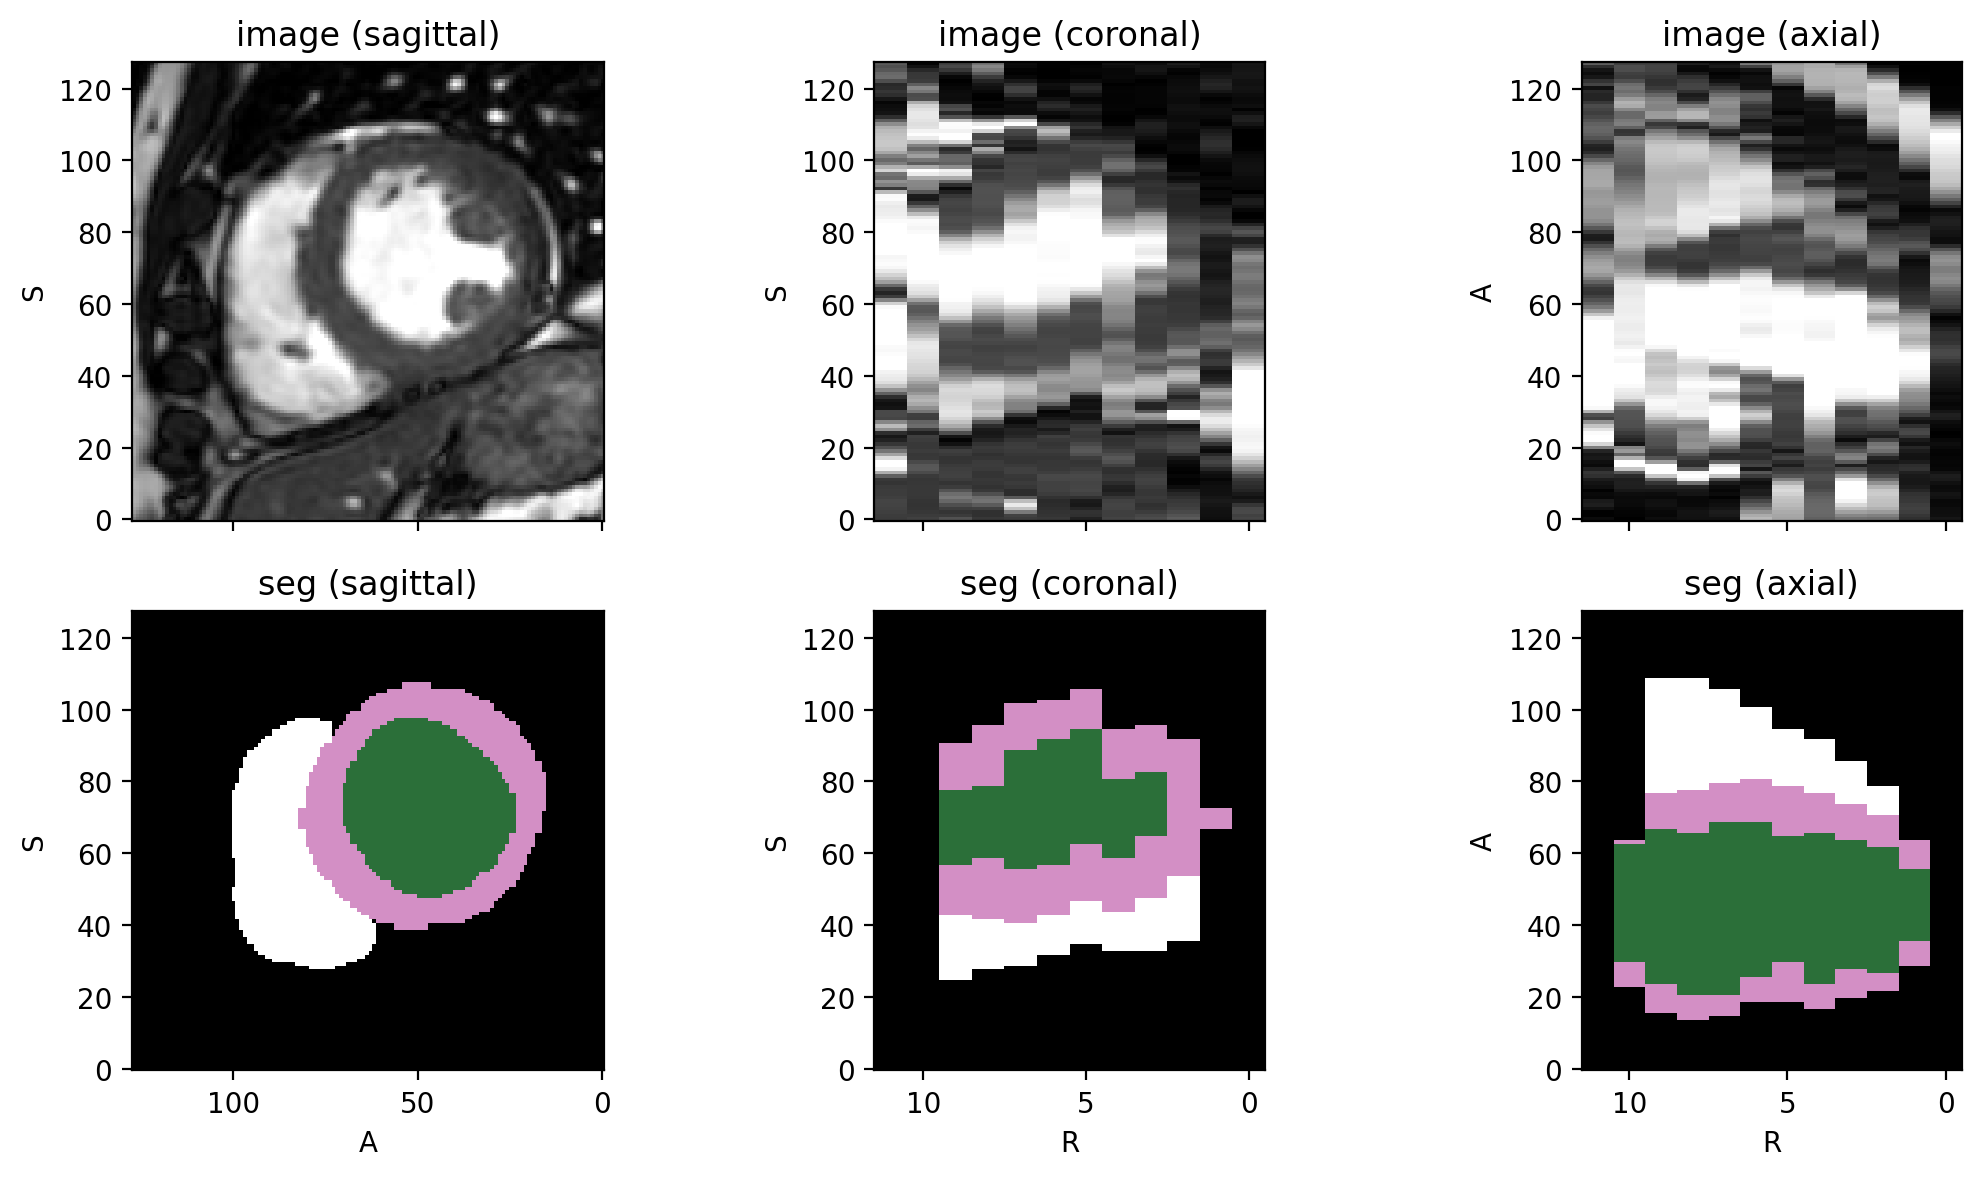

Subject(Keys: ('image', 'seg', 'id'); images: 2)
ScalarImage(shape: (2, 128, 128, 12); spacing: (0.99, 1.08, 9.60); orientation: PIL+; dtype: torch.FloatTensor; memory: 1.5 MiB)
LabelMap(shape: (2, 128, 128, 12); spacing: (0.99, 1.08, 9.60); orientation: PIL+; dtype: torch.FloatTensor; memory: 1.5 MiB)


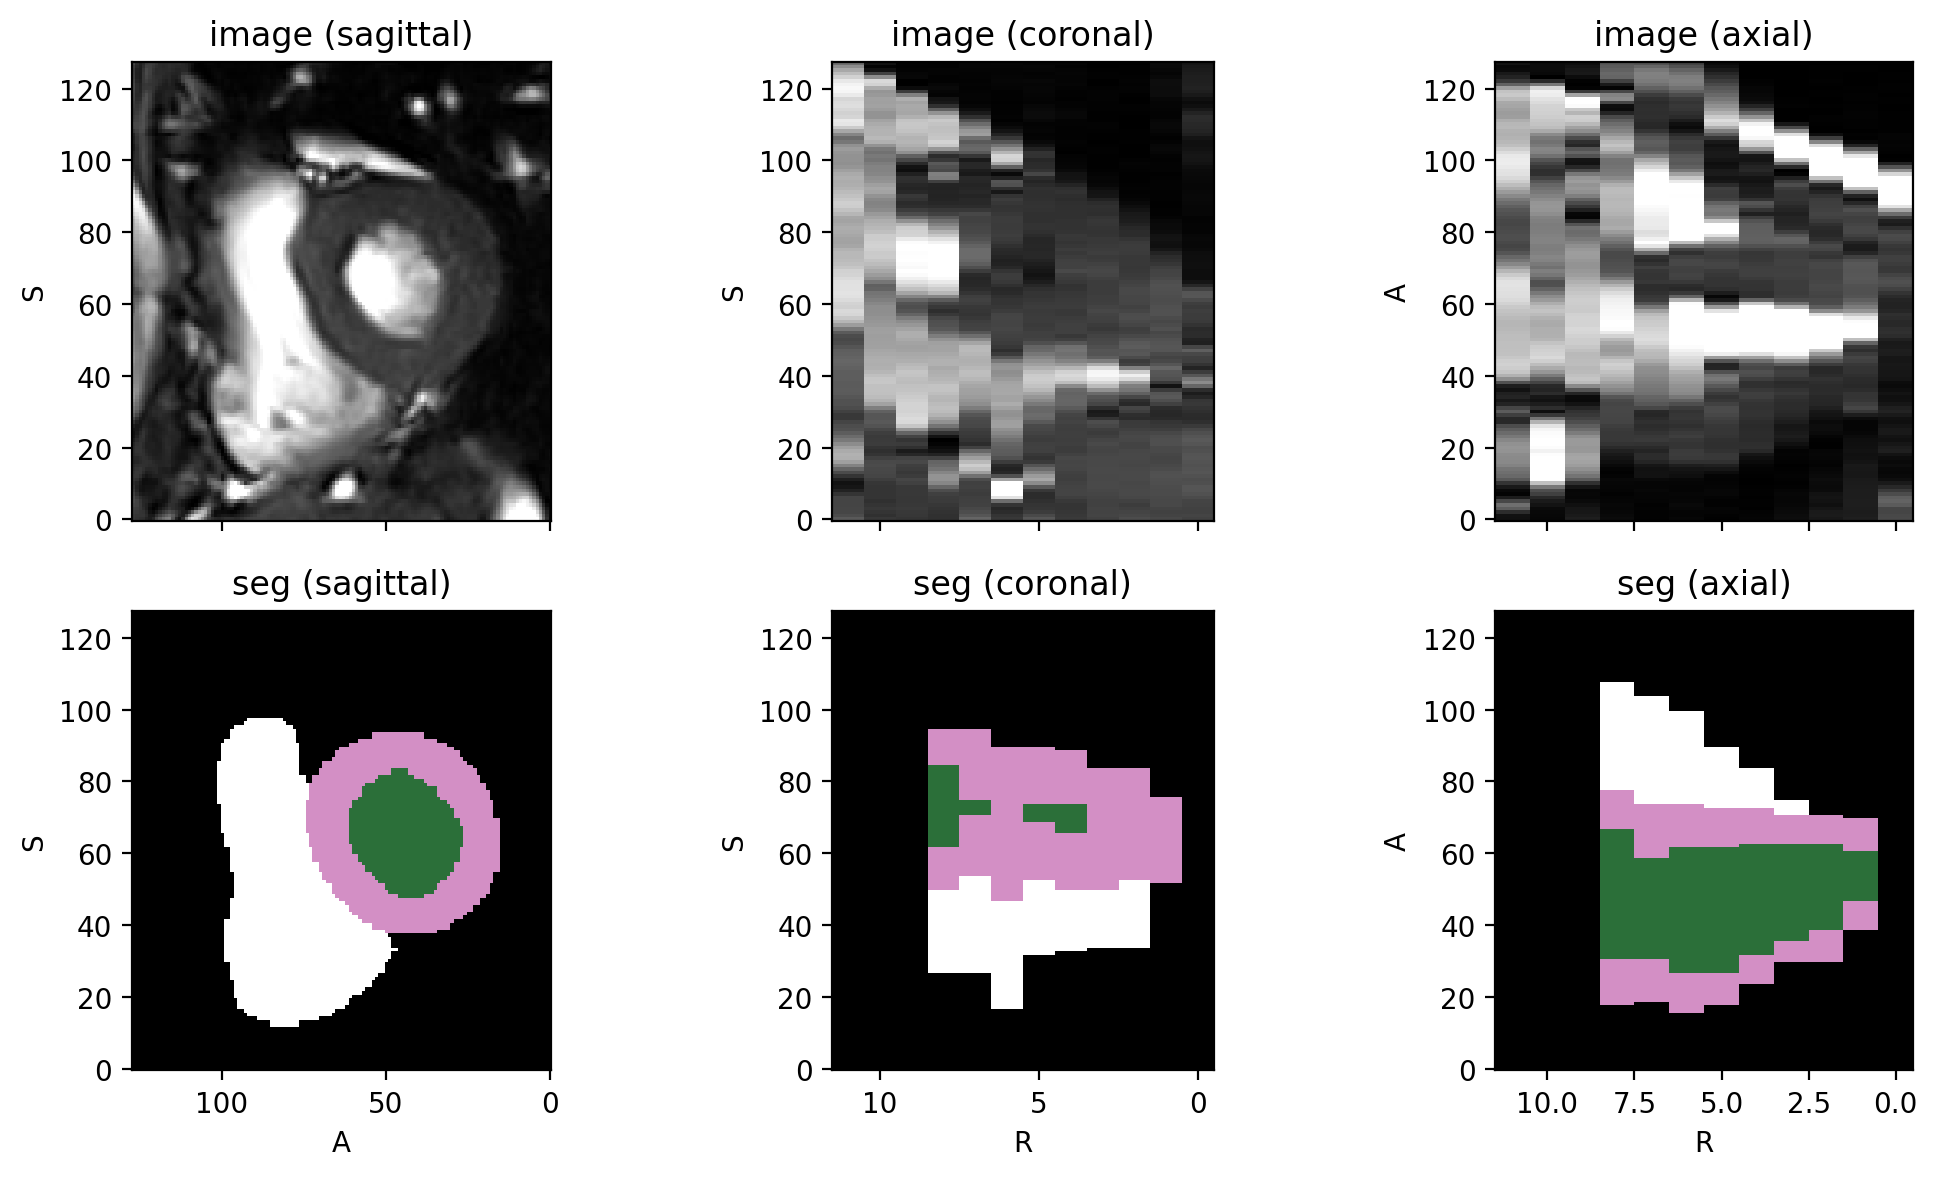

Subject(Keys: ('image', 'seg', 'id'); images: 2)
ScalarImage(shape: (2, 128, 128, 14); spacing: (1.10, 0.85, 10.00); orientation: PIL+; dtype: torch.FloatTensor; memory: 1.8 MiB)
LabelMap(shape: (2, 128, 128, 14); spacing: (1.10, 0.85, 10.00); orientation: PIL+; dtype: torch.FloatTensor; memory: 1.8 MiB)


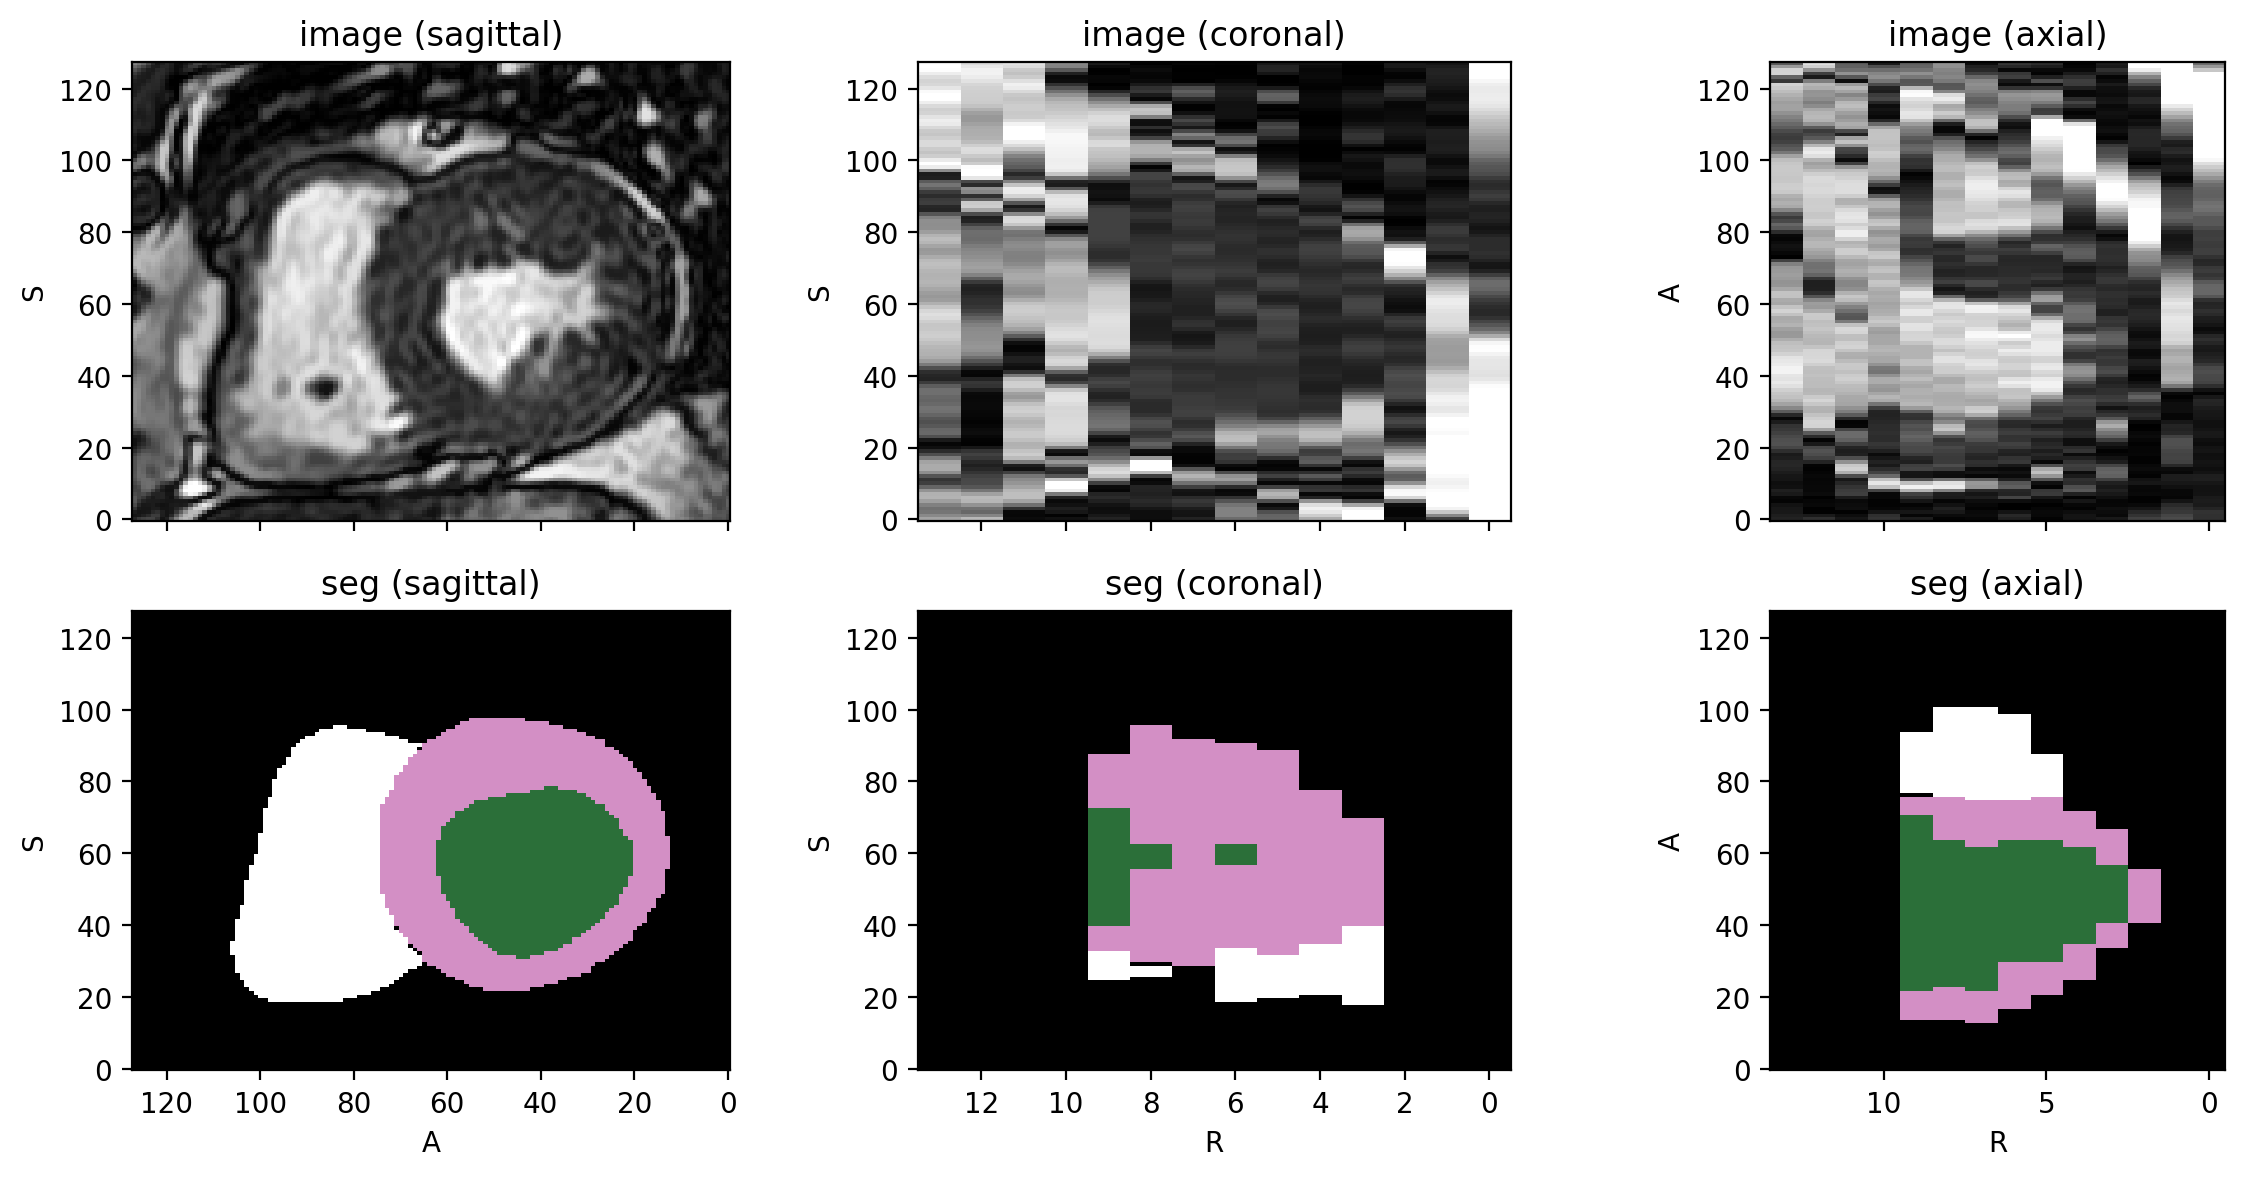

In [40]:
for i in range(4):
    visualize_subject(vendor_datasets_3D[i][0])

# Train on only one Vendor 

In [41]:
def initialize_model():
    model = UNet(
        in_channels=1,
        out_classes=4,
        dimensions=2,
        num_encoding_blocks=5,
        out_channels_first_layer=16,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    )

    optimizer = torch.optim.AdamW(model.parameters())
    criterion = nn.BCEWithLogitsLoss()
    return model, optimizer, criterion


def load_model(model_name):
    model, optimizer, criterion = initialize_model()
    checkpoint = torch.load(f'models/{model_name}.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    meta = checkpoint['metadata']
    num_epochs = meta['num_epochs']
    train_losses = meta['train_losses']
    valid_losses = meta['valid_losses']

    return model, optimizer, num_epochs, train_losses, valid_losses


In [42]:
train_dataset = load_vendor_2D("F", metadata, transform)
valid_dataset = load_vendor_2D("A", metadata, transform)

print("Train dataset length:", len(train_dataset))
print("Validation dataset length:", len(valid_dataset))

3it [00:00, 20.08it/s]

317it [00:11, 27.00it/s]


Data/M&Ms/OpenDataset/ Dataset size: 1770 subjects


317it [00:02, 108.29it/s]


Data/M&Ms/OpenDataset/ Dataset size: 442 subjects
Train dataset length: 1770
Validation dataset length: 442


In [44]:
num_epochs = (30)
batch_size = 32
num_classes = 4
num_workers = 10
save = True
model_name = "rescale_95_percentile"


model, optimizer, criterion = initialize_model()

model = train_model(model, 
                    optimizer, 
                    criterion, 
                    device,  
                    train_dataset, 
                    valid_dataset,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    num_epochs=num_epochs,
                    verbose=3,
                    save=save,
                    model_name= model_name
                    )

  3%|▎         | 1/30 [00:03<01:41,  3.50s/it]

Epoch [1/30]], Loss: 0.5709, Validation Loss: 0.5146


 37%|███▋      | 11/30 [00:39<01:06,  3.52s/it]

Epoch [11/30]], Loss: 0.0476, Validation Loss: 0.0760


 70%|███████   | 21/30 [01:15<00:32,  3.67s/it]

Epoch [21/30]], Loss: 0.0255, Validation Loss: 0.0871


100%|██████████| 30/30 [01:48<00:00,  3.61s/it]


In [45]:
model, optimizer, criterion = initialize_model()
model, optimizer, num_epochs, train_losses, valid_losses = load_model(model_name)

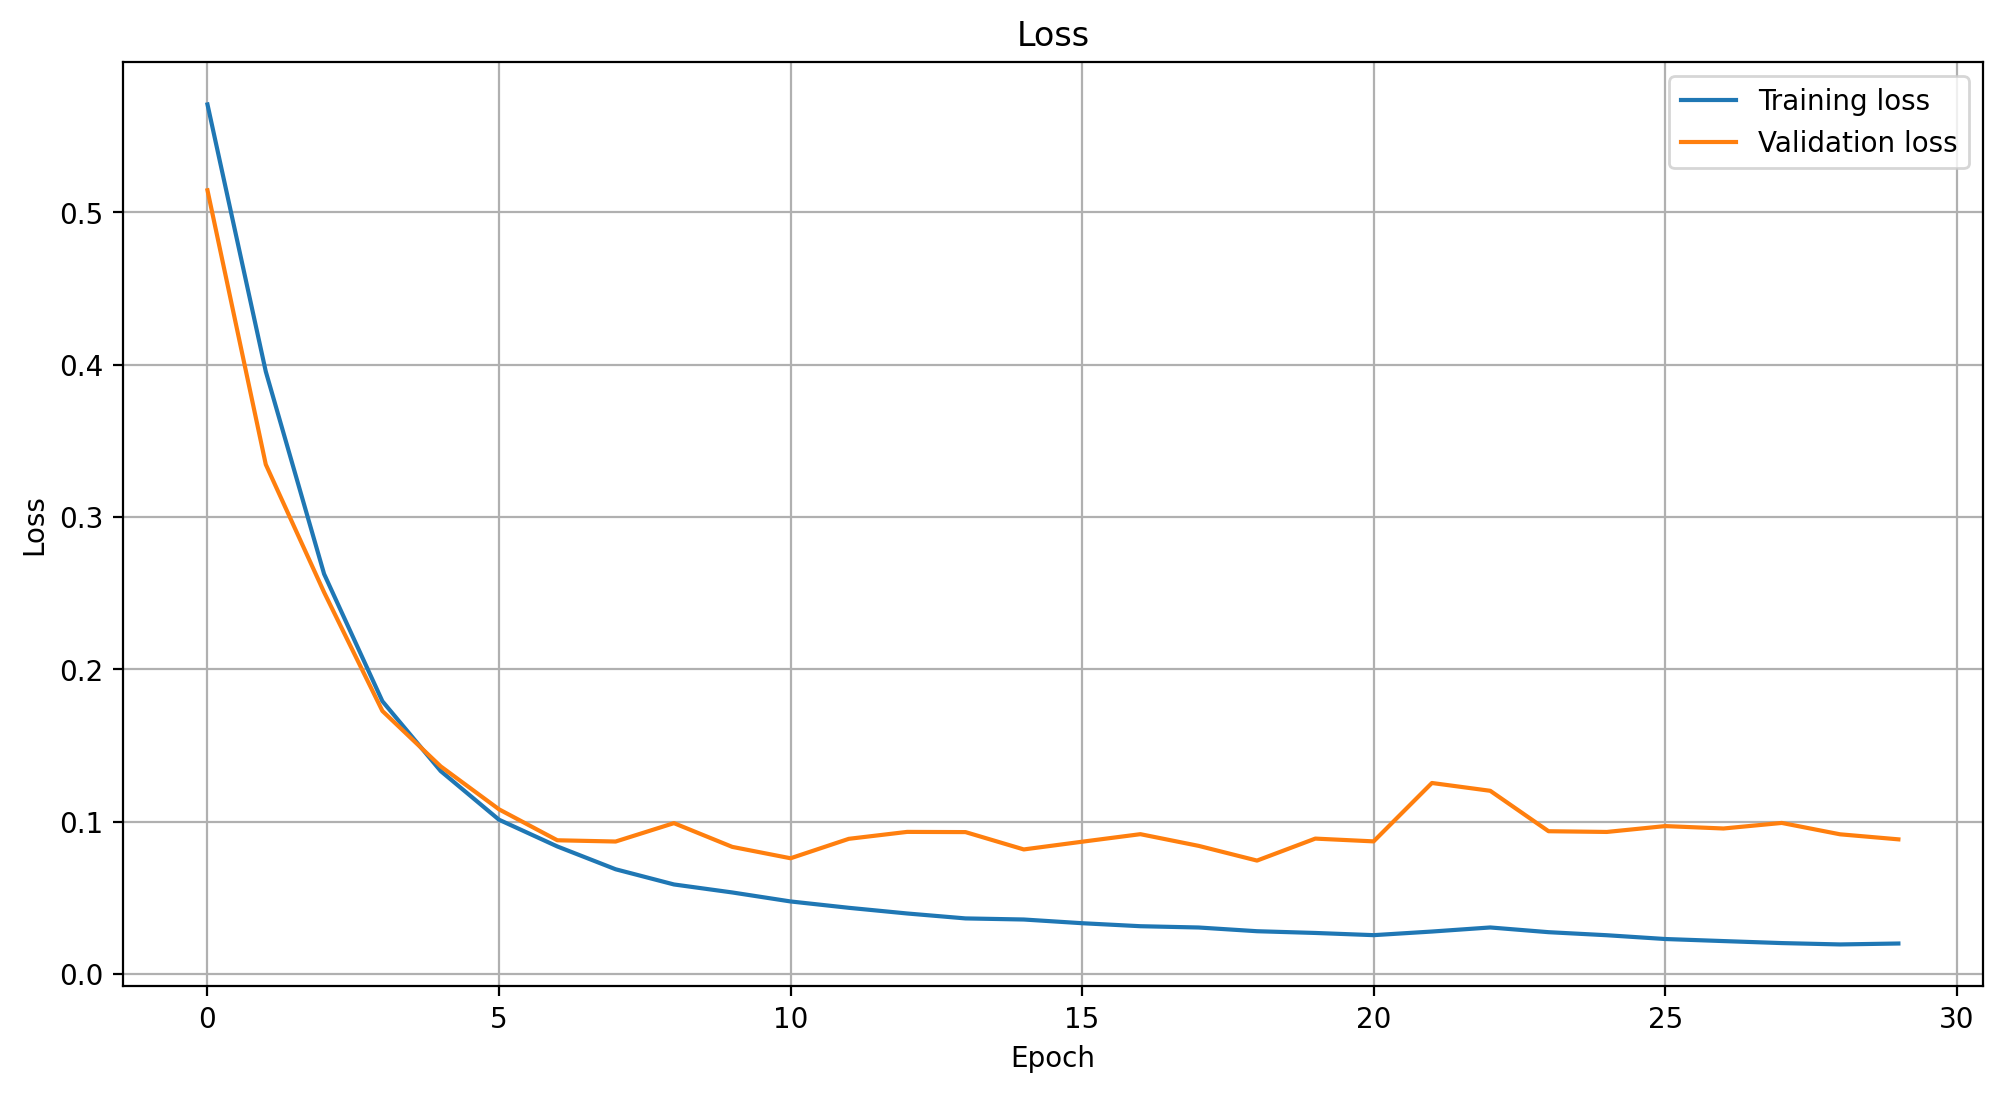

In [46]:
plt.plot(range(num_epochs) , train_losses, label="Training loss")
plt.plot(range(num_epochs) , valid_losses, label="Validation loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.grid(True)
plt.legend()
plt.show()

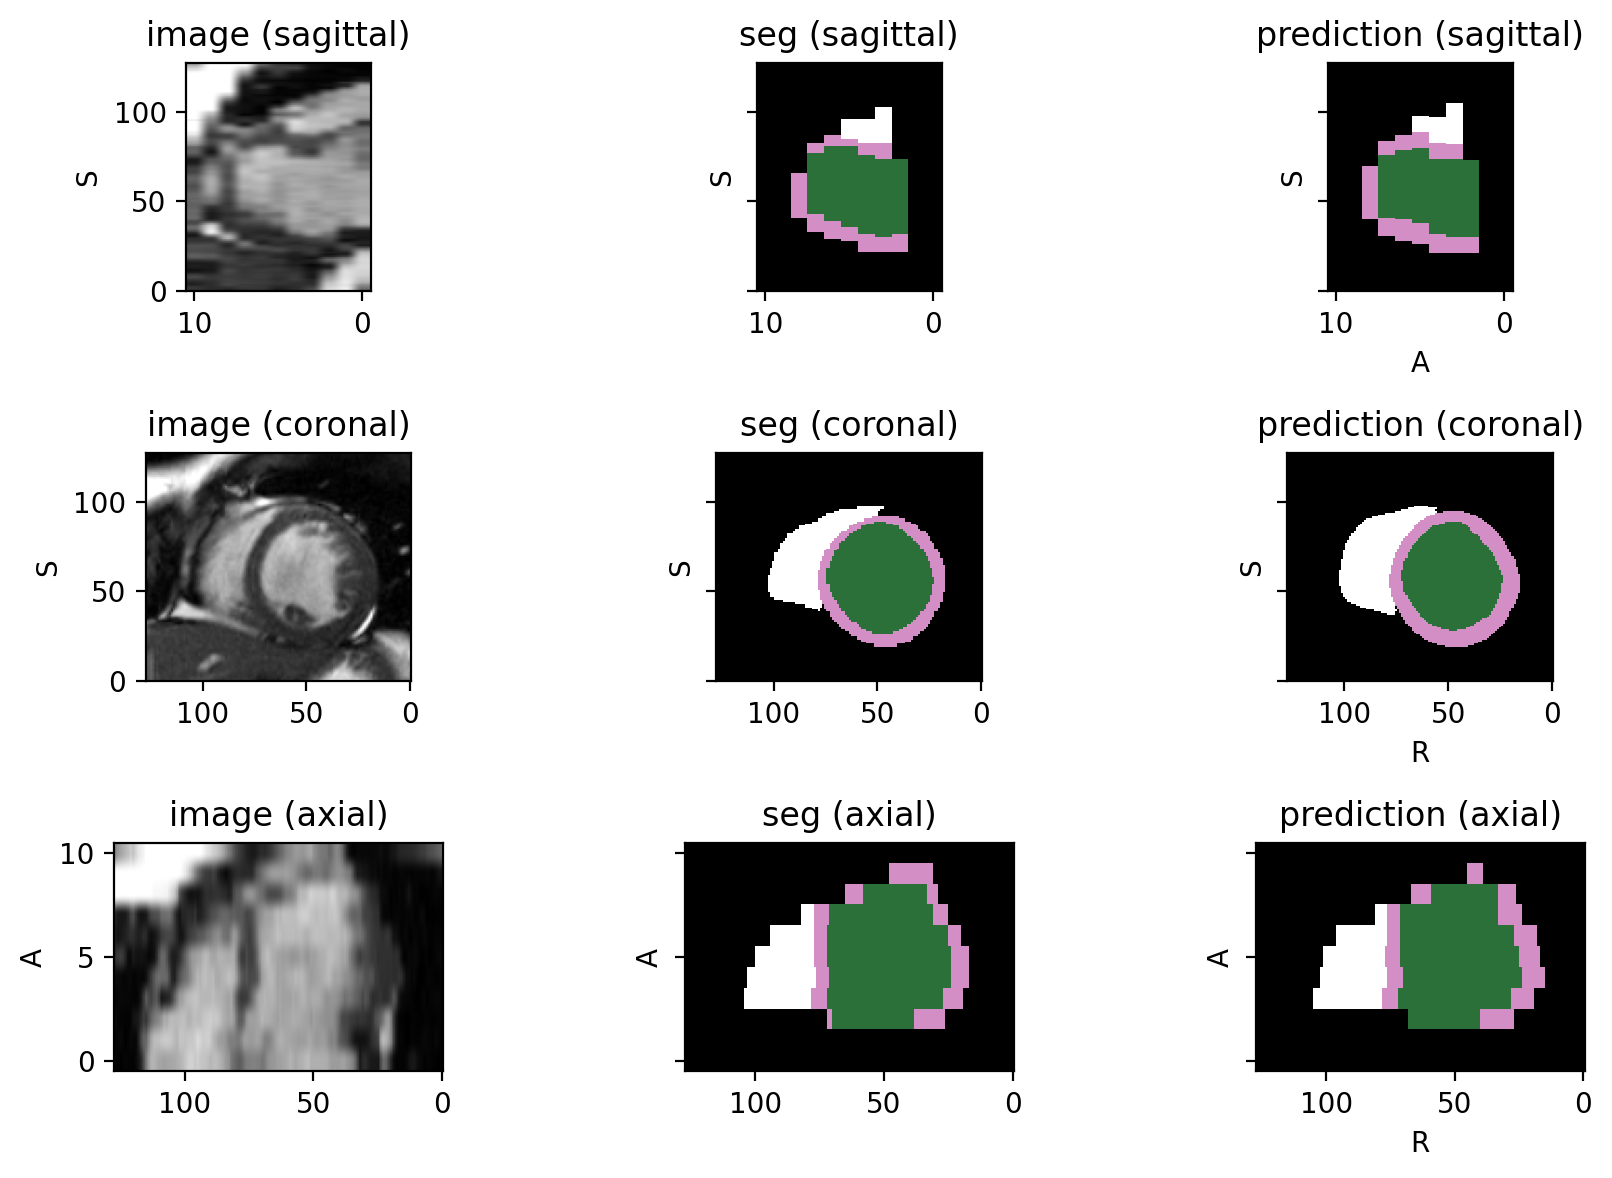

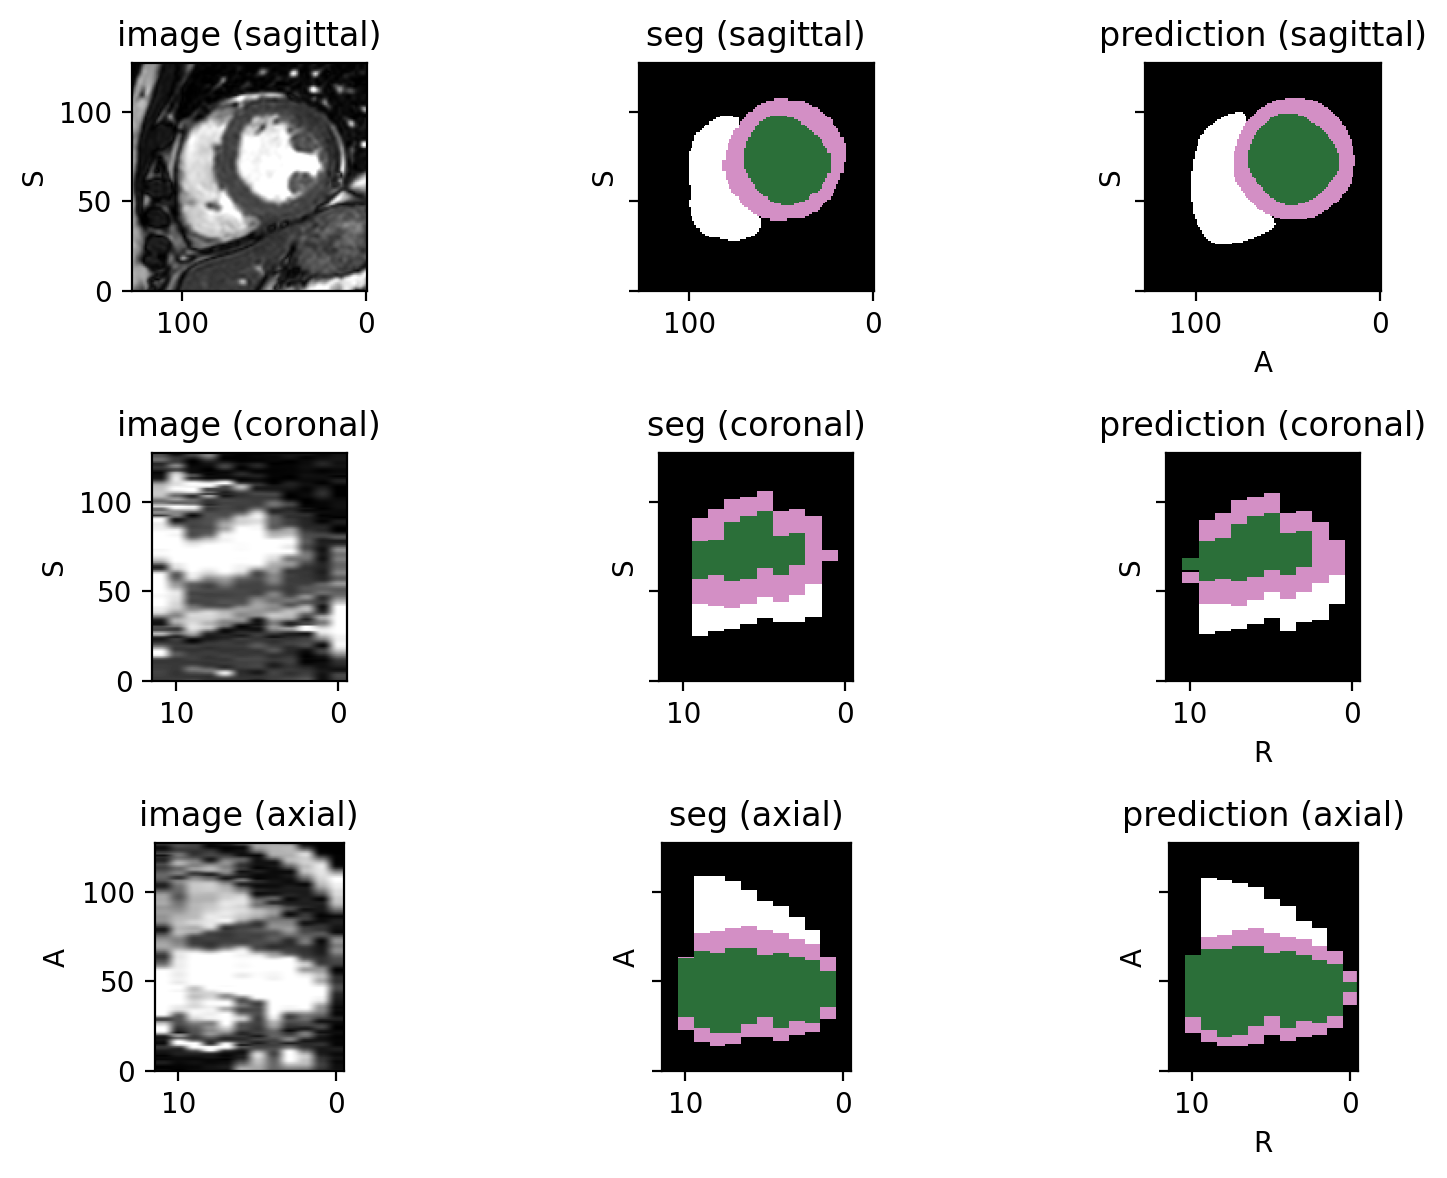

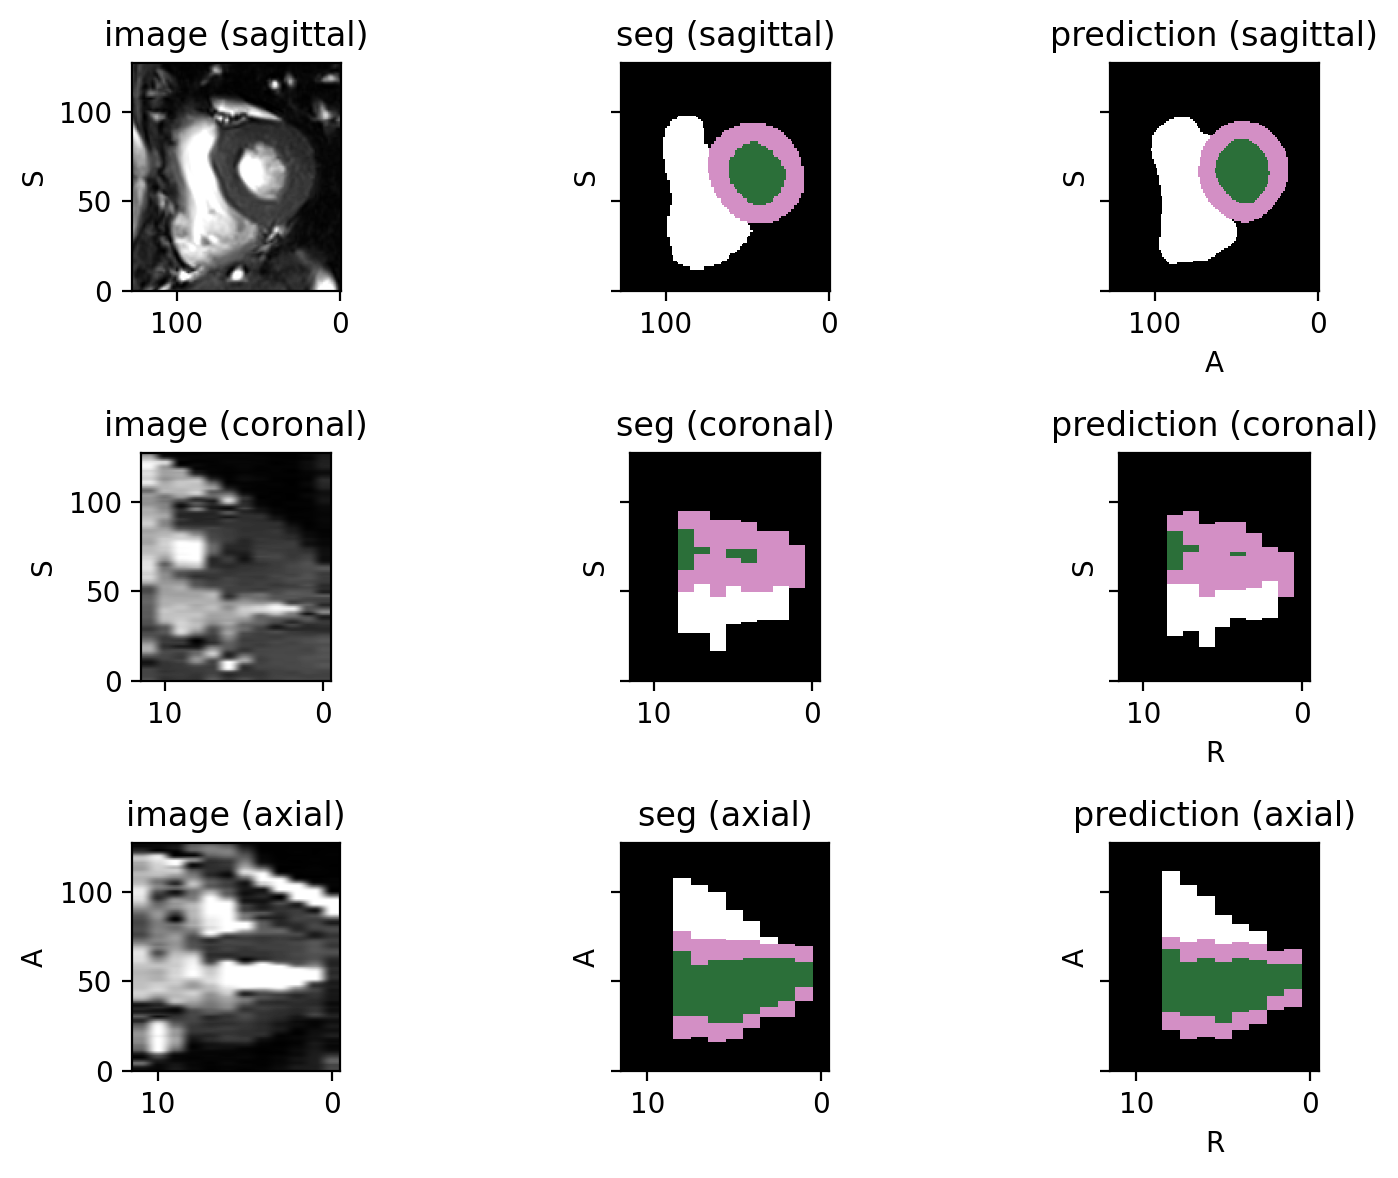

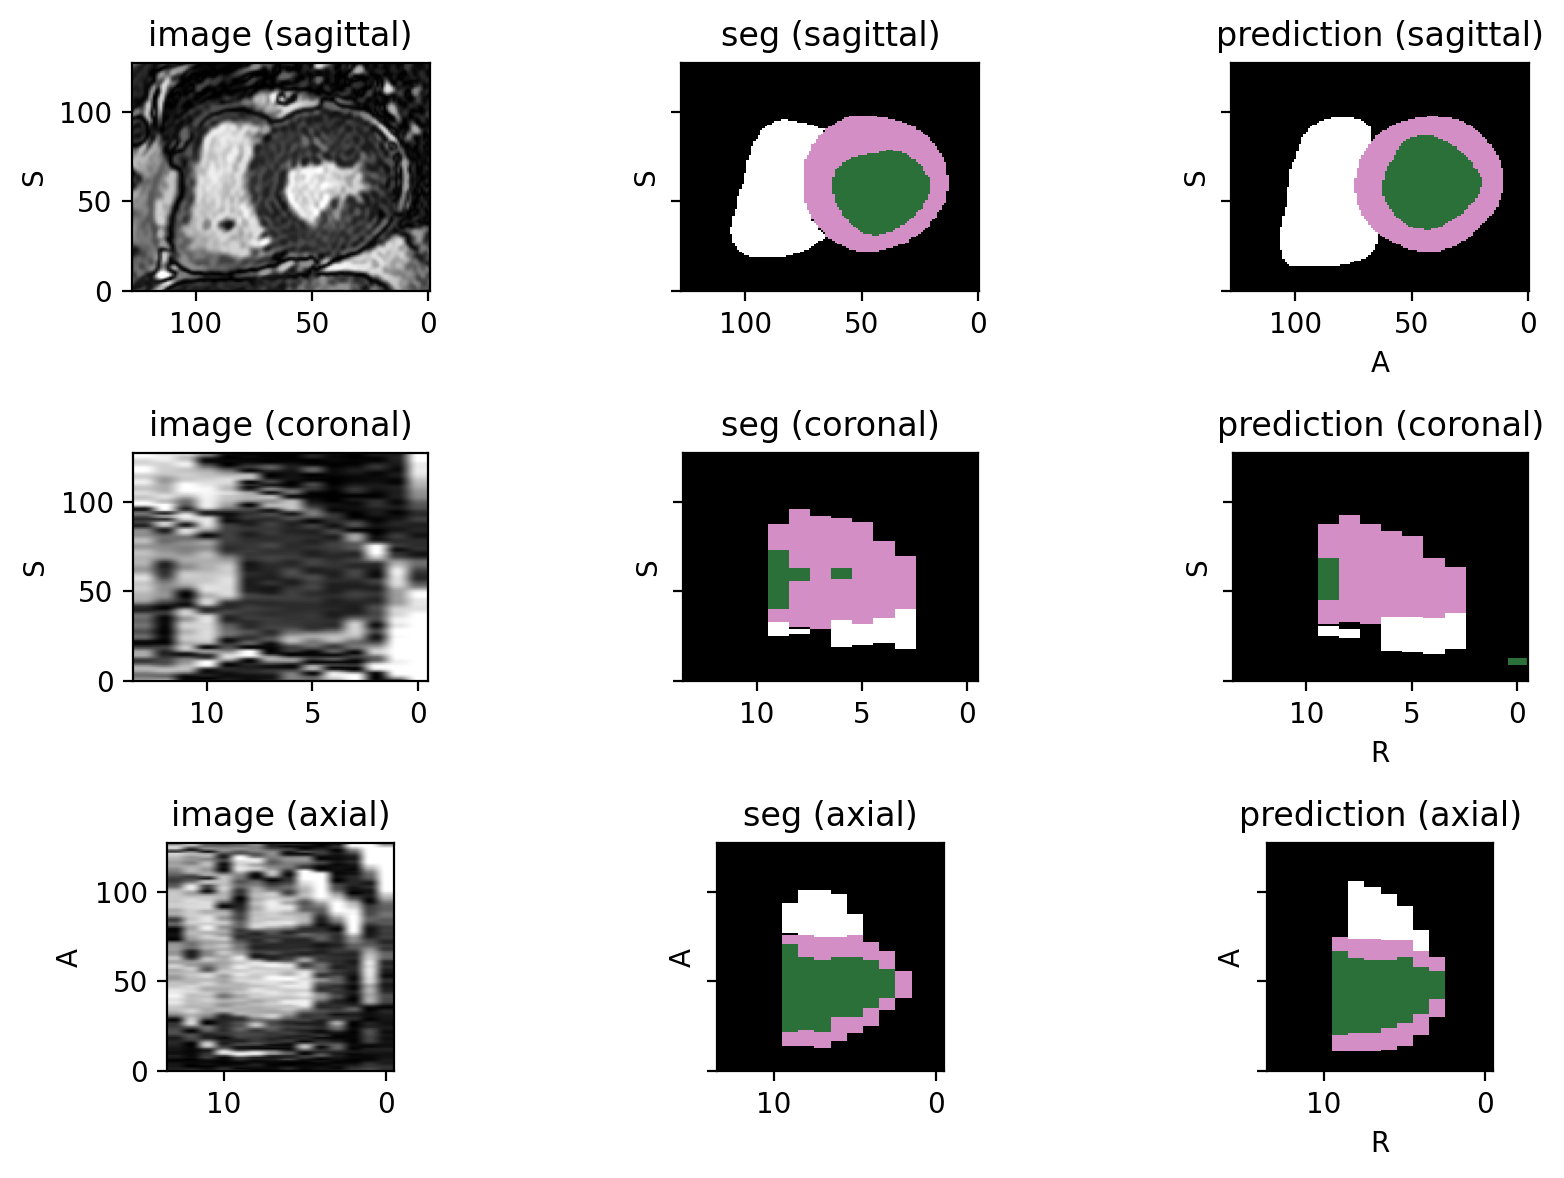

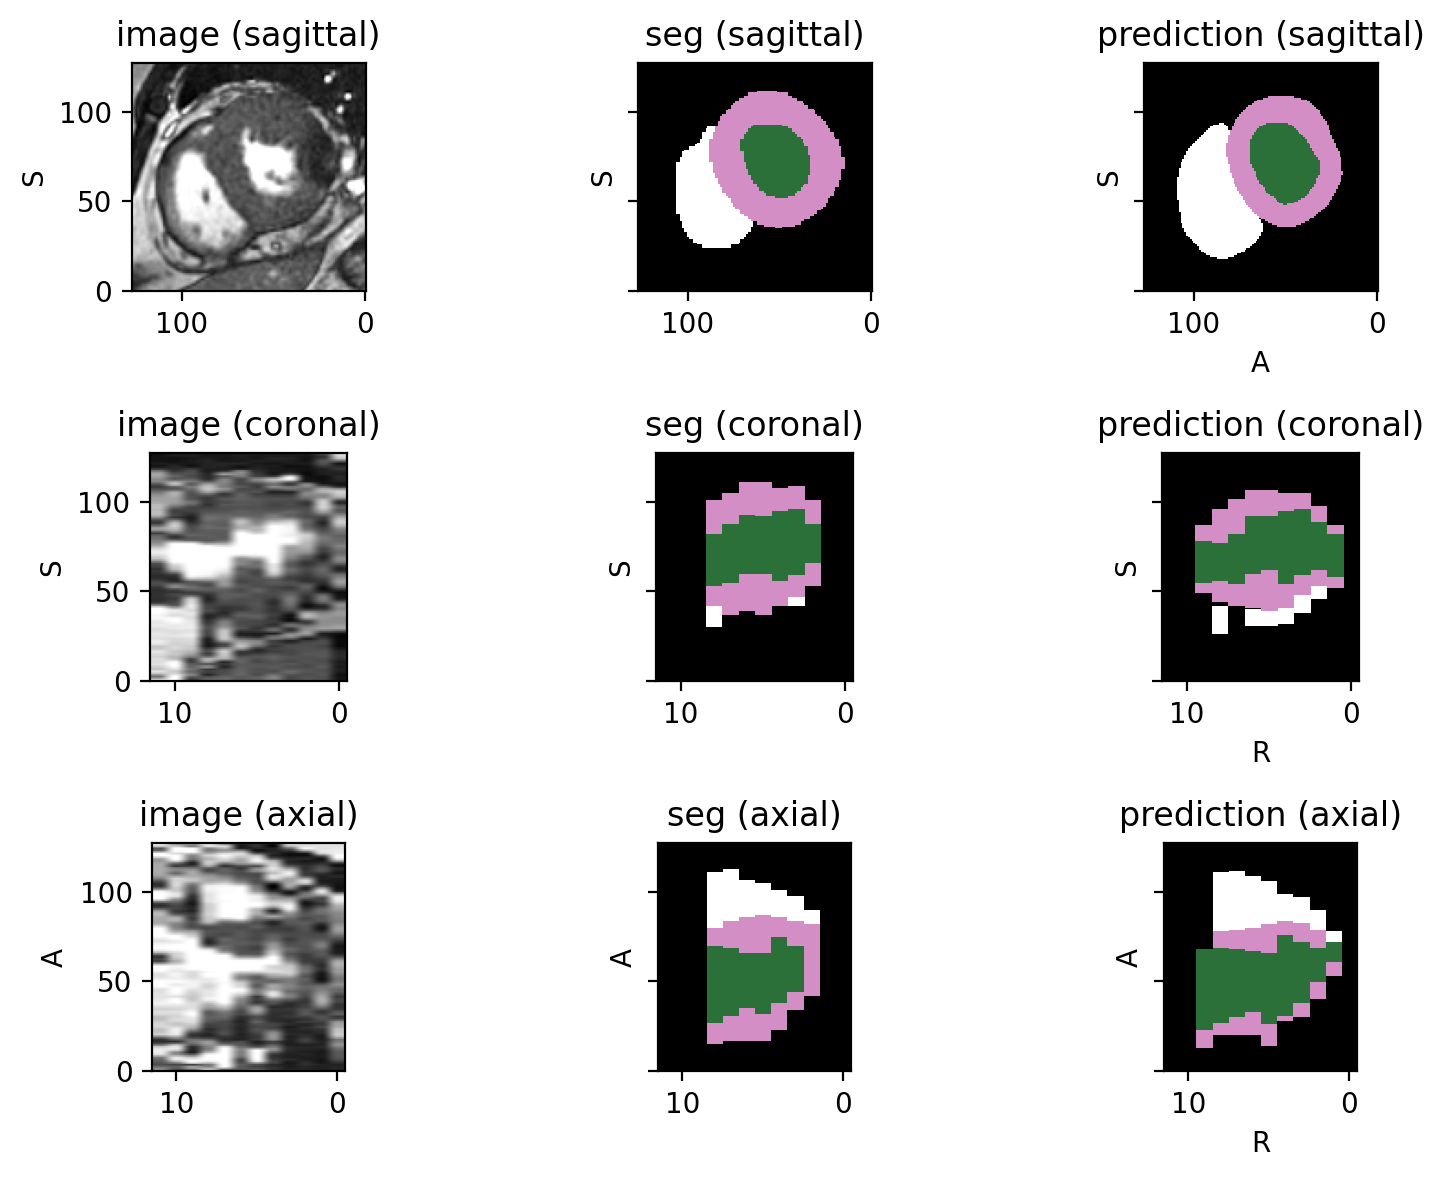

In [47]:
for i in range(len(vendors)):
    # Get data for one subject
    one_subject = vendor_datasets_3D[i][0]
    visualize_predictions_3D(model, one_subject, device)

In [48]:
results = metadata[['Vendor', 'Centre']].copy()

results = results.assign(Dice_BG=None, Dice_LV=None, Dice_MYO=None, Dice_RV=None)
results = results.assign(IoU_BG=None, IoU_LV=None, IoU_MYO=None, IoU_RV=None)
results = results.assign(HD_BG=None, HD_LV=None, HD_MYO=None, HD_RV=None)


for dataset_3D in vendor_datasets_3D:
    for i in range(len(dataset_3D)):
        # Get data for one subject
        subject = dataset_3D[i]
        labels = subject.seg.data 
        id = subject.id
        vendor = metadata.loc[id].Vendor
        
        # Make predictions
        c, x, y, z = labels.shape
        labels_stacked = labels.permute((0,3,1,2)).reshape(c*z ,x, y).long()
        predictions = predict_3D(model, subject, device)

        # Run multi-class evaluation
        dc = list(evaluate(labels_stacked, predictions, metric="Dice", multi_class=True, n_classes=4))
        jc = list(evaluate(labels_stacked, predictions, metric="Jaccard", multi_class=True, n_classes=4))
        hd = list(evaluate(labels_stacked, predictions, metric="AHD", multi_class=True, n_classes=4))
                                      
        results.loc[id, results.columns[2:]]  = dc + jc + hd


results.to_csv(f'Results/{model_name}.csv', index=True)